# Problem Set 5: Neural Networks

**Release Date:** 27 Oct 2025

**Due Date:** 15 Nov 2025

## Overview

While fundamental understanding is crucial and the ability to build things from scratch is helpful, it can be unnecessarily time consuming. In Deep Learning (DL) models like neural networks with many layers, backpropagating manually is error-prone, and specifying the exact behaviour of every layer from first principles would be unreasonably tedious. We find it critical to be familiar with **at least one** Machine Learning library for pragmatic purposes.

![PyTorch](images/logo.png)

`PyTorch` is one of the most widely-used DL libraries. It offers a very Pythonic API to build layers and compose them together. In fact, data processing is also made easy using the multitude of tools and wrappers that are at your disposal. Of course, there are other popular libraries such as `TensorFlow`, but they require you to understand "computation graphs", which we feel makes it less accessible for beginners.

In **Problem Set 5**, we will guide you through the `PyTorch` API by having you build a simple deep neural network and training it locally on your system via backpropagation and stochastic gradient descent. Subsequently, you will be building a __Convolutional Neural Network__ (CNN/ConvNet) and training it on two datasets, *MNIST* and *CIFAR-10*, and learn __data augmentation__ to enhance your dataset. We will then learn the details of RNN, their applications to sequential data, and using a RNN to model and predict patterns in time-series data. Finally, we shall explore the incorporation of attention layers as a first step toward building a transformer architecture.

### Structure of this Notebook
While this problem set is undeniably longer, you might notice a lot of the cells function as **Demos**, leaving only a small proportion as **Tasks** for you to complete. These **Demos** walk through certain building blocks which are likely to help you build a deeper understanding, whereas the **Tasks** are more application-focused (i.e. making use of `PyTorch`'s powerful API). There is also a separate file `ps5_supplementary.ipynb` which explains certain concepts in greater detail. While optional to read, we encourage you to do so!

### Required Files
* ps5.ipynb
* data/
    * review_train.csv
    * review_test.csv

### Plagiarism Policy

Please refer to our [Course Policies](https://canvas.nus.edu.sg/courses/77861/pages/course-policies)

_Honour Code: Note that plagiarism will not be condoned! You may discuss with your classmates and check the internet for references, but you MUST NOT submit any code/report/explanation that is copied directly from other sources!_

### Post-Problem Set Survey
Your feedback is important to us! After completing Problem Set 5, please take a moment to share your thoughts by filling out this [survey](https://coursemology.org/courses/3095/surveys/2719).

### Imports

The following lines of code import packages and functions that are necessary
for the following tasks.

As a reminder, please **do not** modify the following lines of code by adding,
removing or modifying the specified imports. 

In [1]:
# RUN THIS CELL FIRST
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
from numpy import allclose, isclose

from collections.abc import Callable

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# 1 - Neural Networks using PyTorch layers
Before starting, we recommend reading **Extra Chapter 1** in `ps5_supplementary.ipynb` to understand `PyTorch` tensors, and get an idea of how one might implement gradient descent without relying `PyTorch`. Then, you'll appreciate the convenience of the powerful `PyTorch` library!

### Demo 1.1 - nn.Module

The `nn.Module` class is an interface that houses two main methods: `__init__`, where we instantiate our layers and activation functions, and `forward`, that performs the forward pass.

To create our own neural network, we will inherit from the nn.Module parent class and call `super().__init__()` within our constructor to create our module. Next, we will implement the `forward` function within our class so we can call it from our module to perform the forward pass. 

In this example, we define a custom LinearLayer class that inherits from nn.Module. The __init__ method initializes the weight and bias parameters as nn.Parameter objects, which are special types of tensors that require gradients to be computed during the backward pass.

The forward method defines the forward pass of the linear layer. It takes a tensor x as input and computes the matrix multiplication of x and self.weight using the torch.matmul function, and then adds self.bias.

We also created our own activation function which uses `torch.sin` by inheriting from nn.Module.

Finally, in our Model, we can combine our own LinearLayers together with our SineActivation to process our input data using the forward function. In later sections, you will see how we can train our models.

In [2]:
# Define a linear layer using nn.Module
class LinearLayer(nn.Module):
    """
    Linear layer as a subclass of `nn.Module`.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim))
        self.bias = nn.Parameter(torch.randn(output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.matmul(x, self.weight) + self.bias
    
class SineActivation(nn.Module):
    """
    Sine activation layer.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

class Model(nn.Module):
    """
    Neural network created using `LinearLayer` and `SineActivation`.
    """
    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super(Model, self).__init__()
        self.l1 = LinearLayer(input_size, hidden_size)
        self.act = SineActivation()
        self.l2 = LinearLayer(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
    
input_size = 1
hidden_size = 1
num_classes = 1

model = Model(input_size, hidden_size, num_classes)

x = torch.tensor([[1.0]])
output = model(x)
print("Original value: ", x)
print("Value after being processed by Model: ", output)

Original value:  tensor([[1.]])
Value after being processed by Model:  tensor([[-1.3733]], grad_fn=<AddBackward0>)


_Extra: We can also define a `backward` function to perform backpropagation which will not be required in this problem set._

In the following trivial example, the Squared module takes an input x and returns x**2. The backward method calculates the gradient of the output with respect to the input, based on the gradients of the output grad_output.

We can define the backward function for functions that are not fully differentiable that we still wish to use in our neural network.

In [3]:
class Squared(nn.Module):
    """
    Module that returns x**2.
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.x = x
        return x**2

    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        grad_input = 2 * self.x * grad_output
        return grad_input

### Demo 1.2 - Activation Functions

Activation functions introduce non-linearity into the output of a neuron, allowing the NN to learn non-linear functions. Otherwise, our entire network effectively becomes equivalent to a linear model, preventing us from modelling complex representations based on our inputs. Thus, activation functions are essential, and the choice of activation function can impact your model's effectiveness depending on your input data and the problem you're trying to solve.

####  For the hidden layers, there are several commonly used activation functions:

**ReLU** (Rectified Linear Unit): Maps non-positive inputs to 0 and positive inputs to their original value. It is mainly used in hidden layers because it is fast to compute, has sparse activations, and helps to mitigate the vanishing gradient problem, where the gradients can become very small and cause the model to learn slowly.

**Tanh** (Hyperbolic Tangent): Maps input values to the range [-1, 1]. It is similar to Sigmoid, but instead of producing output values in the range [0, 1], it produces output values in the range [-1, 1]. Tanh is useful for solving problems where you want the activations to be centered around zero, such as in recurrent neural networks.

**Sigmoid**: Maps its input values to the range [0, 1]. It is less commonly used in hidden layers because it has a relatively slow convergence rate and can introduce saturation, where the output values become very small or very large, which can make it difficult for the gradients to flow through the model.

<div>
<img src="images/sigmoid_tanh_relu.png" width="300"/>
</div>

#### For the output layer, the choice of activation function depends on the problem you're trying to solve. Here are some common choices:

**Sigmoid**: The Sigmoid activation function maps input values to the range [0, 1]. It is commonly used for binary classification problems where the network produces a probability of one of two classes. In this case, the Sigmoid activation maps the output to a probability distribution over the two classes.

**Softmax**: The Softmax activation function is a generalization of the Sigmoid activation that maps input values to a probability distribution over multiple classes. It is commonly used for multiclass classification problems. The Softmax activation function is used to convert the raw scores produced by the network into a probability distribution over the classes.

**Linear**: For regression problems, we could just finish with a linear layer as we don't have to dramatically morph the output into something particular.

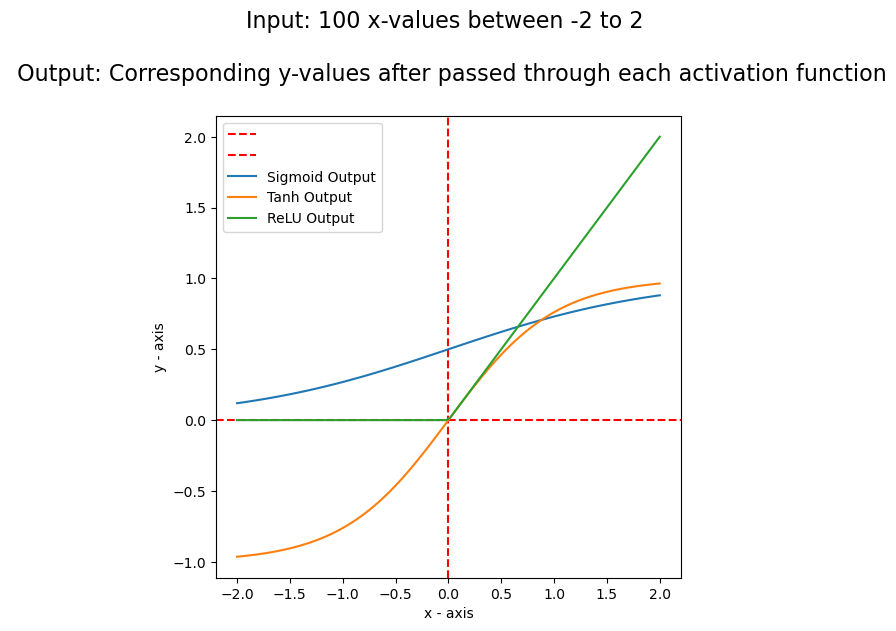

In [4]:
x_sample = torch.linspace(-2, 2, 100)
sigmoid_output = nn.Sigmoid()(x_sample).detach().numpy()
tanh_output = nn.Tanh()(x_sample).detach().numpy()
relu_output = nn.ReLU()(x_sample).detach().numpy()

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title("Input: 100 x-values between -2 to 2 \n\n Output: Corresponding y-values after passed through each activation function\n", fontsize=16)
plt.axvline(x=0, color='r', linestyle='dashed')
plt.axhline(y=0, color='r', linestyle='dashed')
plt.plot(x_sample, sigmoid_output)
plt.plot(x_sample, tanh_output)
plt.plot(x_sample, relu_output)
plt.legend(["","","Sigmoid Output", "Tanh Output", "ReLU Output"])
plt.show()

### Demo 1.3 - Forward pass (NN)

In Extra Chapter 1, we manually created the Linear layers and explicitly specified weights and biases for the forward pass to connect every input neuron to every output neuron. Luckily, we can let `PyTorch` do all that for us instead.

Let's use `nn.Linear(in_dimensions, out_dimensions)` which represents a fully connected layer with bias automatically included. We can also choose to remove the bias column by simply calling `nn.Linear(in_dimensions, out_dimensions, bias=False)` instead.  

<div>
<img src="images/toy_nn.png" width="400"/>
</div>

With `PyTorch`, it is easy to combine many different types of layers and activation functions to create neural networks.

The model has been built for you in `__init__`. We implement the `forward` method, making use of the layers `self.l1`, `self.l2`, and the activation function `self.relu`. Observe that we combine the linear layers and the activation function in the forward pass function!

_Extra: PyTorch has many other layers implemented for various model architectures.  
You can read more in the glossary as well as in the docs: https://pytorch.org/docs/stable/nn.html  
For now, we will only be using fully connected `nn.Linear` layers._

In [5]:
# DEMO
class MyFirstNeuralNet(nn.Module):
    def __init__(self): # set the arguments you'd need
        super().__init__()
        self.l1 = nn.Linear(1, 2) # bias included by default
        self.l2 = nn.Linear(2, 1) # bias included by default
        self.relu = nn.ReLU()
 
    # Task 1.1: Forward pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass to process input through two linear layers and ReLU activation function.

        Parameters
        ----------
        x : A tensor of of shape (n, 1) where n is the number of training instances

        Returns
        -------
            Tensor of shape (n, 1)
        '''
        """ YOUR CODE HERE """
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return(x)
        """ YOUR CODE END HERE """

In [6]:
# Run to check
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)

model = MyFirstNeuralNet()

state_dict = OrderedDict([
    ('l1.weight', torch.tensor([[1.],[-1.]])),
    ('l1.bias',   torch.tensor([-1., 1.])),
    ('l2.weight', torch.tensor([[1., 1.]])),
    ('l2.bias',   torch.tensor([0.]))
])

model.load_state_dict(state_dict)

student1 = model.forward(x_sample).detach().numpy()
output1 = [[3.], [2.], [1.], [0.], [1.]]

assert allclose(student1, output1, atol=1e-5)

### Demo 1.4 - Optimisers in PyTorch
Recall that `PyTorch` can automatically handle the heavy lifting of calculus: when you run **loss.backward()**, the derivative of the loss with respect to a parameter is computed and stored automatically in that parameter's **.grad** attribute.

The **Optimizer** goes one step further—It also automatically uses the calculated gradient to actually update the parameter's value for us. We have the choice of which optimizer to use, as they follow different optimization algorithms like **SGD** or **Adam**.

In the following code example, we simply demo a few basic functionalities of optimisers. Later, we'll see an actual optimizer at work to train a Neural Net.

We first create a tensor x with requires_grad set to True. Next, we define our loss function to be the simple equation $y = x^2 + 2x$. Next, we define an optimiser (in this case Stochastic Gradient Descent, SGD) and pass it our tensor $x$ as a parameter to optimise. After updating the gradient stored in $x$ using `backward()`, we will call the `step()` function to let the optimiser update $x$. We will then set the gradient of our tensor $x$ back to zero using `zero_grad()`.

In [7]:
x = torch.tensor([1.0], requires_grad=True)

#Loss function
y = x ** 2 + 2 * x

# Define an optimizer, pass it our tensor x to update
optimiser = torch.optim.SGD([x], lr=0.1)

# Perform backpropagation
y.backward()

print("Value of x before it is updated by optimiser: ", x)
print("Gradient stored in x after backpropagation: ", x.grad)

# Call the step function on the optimizer to update weight
optimiser.step()

#Weight update, x = x - lr * x.grad = 1.0 - 0.1 * 4.0 = 0.60
print("Value of x after it is updated by optimiser: ", x)

# Set gradient of weight to zero
optimiser.zero_grad()
print("Gradient stored in x after zero_grad is called: ", x.grad)

Value of x before it is updated by optimiser:  tensor([1.], requires_grad=True)
Gradient stored in x after backpropagation:  tensor([4.])
Value of x after it is updated by optimiser:  tensor([0.6000], requires_grad=True)
Gradient stored in x after zero_grad is called:  None


### Demo 1.5 - Training Your First Neural Net

Now, let's make use of an optimiser to train our neural network built earlier in Task 1.1!

We will using `torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)` which implements stochastic gradient descent for us. As mentioned previously, `optimiser.zero_grad()` will set all the gradients to zero to prevent accumulation of previous gradients gathered during backpropagation. `optimiser.step()` tells the optimiser to update the model weights based on the gradients of our parameters.

In our example below, `optimiser.zero_grad()` at the start of the loop clears the gradient from previous iterations of backpropagation. Then after computing loss and making the prediction **y_pred**, we call `loss.backward()` to let `PyTorch` carry out the backpropagation for us. Finally, gradients for each parameter are used to update our model weights using `optimiser.step()`.

Epoch	Loss	
-----	----
 1000	0.3594755232334137
 2000	0.13189837336540222
 3000	0.059779662638902664
 4000	0.030693618580698967
 5000	0.016396211460232735
 6000	0.008692794479429722
 7000	0.004500690381973982
 8000	0.0022789163049310446
 9000	0.001138190971687436
10000	0.0005686055519618094


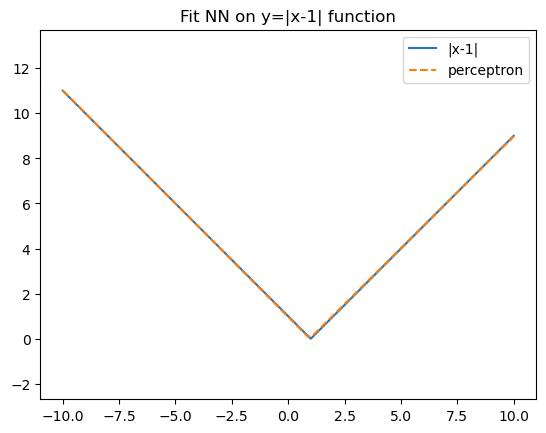

In [8]:
torch.manual_seed(6) # Set seed to some fixed value

epochs = 10000

model = MyFirstNeuralNet()
# the optimizer controls the learning rate
optimiser = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)
loss_fn = nn.MSELoss()

x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = torch.abs(x-1)

print('Epoch', 'Loss', '\n-----', '----', sep='\t')
for i in range(1, epochs+1):
    # reset gradients to 0
    optimiser.zero_grad()
    # get predictions
    y_pred = model(x)
    # compute loss
    loss = loss_fn(y_pred, y)
    # backpropagate
    loss.backward()
    # update the model weights
    optimiser.step()

    if i % 1000 == 0:
        print (f"{i:5d}", loss.item(), sep='\t')

y_pred = model(x)
plt.plot(x, y, linestyle='solid', label='|x-1|')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label='perceptron')
plt.axis('equal')
plt.title('Fit NN on y=|x-1| function')
plt.legend()
plt.show()

### Tip: Save and load models

Your model weights are stored within the model itself.  
You may save/load the model weights:
```
torch.save(model.state_dict(), "path/to/model_state_dict")

model = MyFirstNeuralNet()
model.load_state_dict(torch.load("path/to/model_state_dict"))
```

Alternatively, you can save/load the entire model using
```
torch.save(model, "path/to/model")

model = torch.load("path/to/model")
```

In [9]:
# Run to view your model weights
print("--- Submit the OrderedDict below ---")
print(model.state_dict())

--- Submit the OrderedDict below ---
OrderedDict({'l1.weight': tensor([[-1.0142],
        [ 0.8367]]), 'l1.bias': tensor([ 0.8831, -0.8673]), 'l2.weight': tensor([[0.9906, 1.1831]]), 'l2.bias': tensor([0.0945])})


### Using NN to recognize handwritten digits

Now we will be building a neural network to classify images to their respective digits.  

You will build and train a model on the classic **MNIST Handwritten Digits** dataset. Each grayscale image is a $28 \times 28$ tensor that looks something like:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500" />

MNIST is a classification problem and the task is to take in an input image and classify them into one of ten buckets: the digits from $0$ to $9$. 

### Demo 1.6 - Loading an external dataset

The cell below imports the MNIST dataset, which is already pre-split into train and test sets.  

The download takes approximately 63MB of space.

In [10]:
# DO NOT REMOVE THIS CELL – THIS DOWNLOADS THE MNIST DATASET
# RUN THIS CELL BEFORE YOU RUN THE REST OF THE CELLS BELOW
from torchvision import datasets

# This downloads the MNIST datasets ~63MB
mnist_train = datasets.MNIST("./", train=True, download=True)
mnist_test  = datasets.MNIST("./", train=False, download=True)

x_train = mnist_train.data.reshape(-1, 784) / 255
y_train = mnist_train.targets
    
x_test = mnist_test.data.reshape(-1, 784) / 255
y_test = mnist_test.targets

### Task 1.1 - Define the model architecture and implement the forward pass
Create a 3-layer network in the `__init__` method of the model `DigitNet`.  
These should all be `Linear` layers and correspond to the following architecture:

<div>
<img src="images/img_linear_nn.png", width=700>
</div>

In our data, a given image $x$ has been flattened from a 28x28 image to a 784-length array.

After initializing the layers, stitch them together in the `forward` method. Your network should look like so:

$$x \rightarrow \text{Linear(512)} \rightarrow \text{ReLU} \rightarrow \text{Linear(128)} \rightarrow \text{ReLU} \rightarrow \text{Linear(10)} \rightarrow \text{Softmax} \rightarrow \hat{y}$$

**Softmax Layer**: The final softmax activation is commonly used for classification tasks, as it normalizes the input vector into a probability mass vector which sums up to 1. This is a natural choice of final activation when trying to model probability distributions, like we are doing here.

*Note: When using `torch.softmax(...)` on the final layer, ensure you are applying it on the correct dimension (as you did in NumPy via the `axis` argument in popular methods)*

In [11]:
class DigitNet(nn.Module):
    def __init__(self, input_dimensions: int, num_classes: int): # set the arguments you'd need
        super().__init__()
        """
        YOUR CODE HERE
        - DO NOT hardcode the input_dimensions, use the parameter in the function
        - Your network should work for any input and output size 
        - Create the 3 layers (and a ReLU layer) using the torch.nn layers API
        """
        """ YOUR CODE HERE """
        self.l1 = nn.Linear(input_dimensions, 512)
        self.l2 = nn.Linear(512, 128)
        self.l3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        """ YOUR CODE END HERE """
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass for the network.
        
        Parameters
        ----------
        x : Input tensor (batch size is the entire dataset)

        Returns
        -------
            The output of the entire 3-layer model.
        """
        
        """
        YOUR CODE
        
        - Pass the inputs through the sequence of layers
        - Run the final output through the Softmax function on the right dimension!
        """
        """ YOUR CODE HERE """
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        output = F.softmax(x, dim=1)
        return output
        """ YOUR CODE END HERE """

In [12]:
# Test cases
model = DigitNet(784, 10)
assert [layer.detach().numpy().shape for name, layer in model.named_parameters()] \
        == [(512, 784), (512,), (128, 512), (128,), (10, 128), (10,)]

### Task 1.2 - Training Loop

Similar to what we did above, implement the function `train_model` that performs the following for every epoch/iteration:

1. set the optimizer's gradients to zero
2. forward pass
3. calculate the loss
4. backpropagate using the loss
5. take an optimzer step to update weights

This time, use the Adam optimiser to train the network.
<br/>
Use Cross-Entropy Loss, since we are performing a classification.
<br/>
Train for 20 epochs.  

*Note: refer to the command glossary to find out how to instantiate optimisers, losses, and more*

In [13]:
def train_model(x_train: torch.Tensor, y_train: torch.Tensor, epochs: int = 20):
    """
    Trains the model for 20 epochs/iterations
    
    Parameters
    ----------
        x_train : A tensor of training features of shape (60000, 784)
        y_train : A tensor of training labels of shape (60000, 1)
        epochs  : Number of epochs, default of 20
        
    Returns
    -------
        The final model 
    """
    model = DigitNet(784, 10)

    optimiser = torch.optim.Adam(model.parameters()) # use Adam
    loss_fn = nn.CrossEntropyLoss()   # use CrossEntropyLoss

    for i in range(epochs):
        """ YOUR CODE HERE """
        optimiser.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimiser.step()
        """ YOUR CODE END HERE """

    return model
                
digit_model = train_model(x_train, y_train)

In [14]:
# Test cases
x_train_new = torch.rand(5, 784, requires_grad=True)
y_train_new = ones = torch.ones(5, dtype=torch.uint8)

assert type(train_model(x_train_new, y_train_new)) == DigitNet

### Demo 1.7 - Explore your model

Now that we have trained the model, let us run some predictions on the model.

true label: 7
pred label: 7


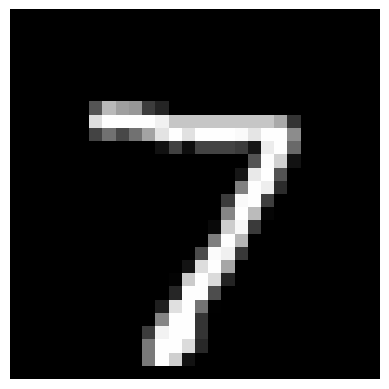

In [15]:
# This is a demonstration: You can use this cell for exploring your trained model

idx = 0 # try on some index

scores = digit_model(x_test[idx:idx+1])
_, predictions = torch.max(scores, 1)
print("true label:", y_test[idx].item())
print("pred label:", predictions[0].item())

plt.imshow(x_test[idx].numpy().reshape(28, 28), cmap='gray')
plt.axis("off")
plt.show()

### Task 1.3 - Evaluate the model

Now that we have trained the model, we should evaluate it using our test set.  
We will be using **accuracy** (Boolean; whether the model predicted the correct label) to measure performance.  

Recall that our model takes in a $(n$ x $784)$ tensor and returns a $(n$ x $10)$ tensor of probability scores for each of the 10 classes. But our final guess should be one label, not a probability vector. An extra step is needed here to extract the best guess from the output vector!

In [16]:
def get_accuracy(scores: torch.Tensor, labels: torch.Tensor) -> int | float:
    """
    Helper function that returns accuracy of model
    
    Parameters
    ----------
        scores : The raw softmax scores of the network
        labels : The ground truth labels
        
    Returns
    -------
        Accuracy of the model. Return a number in range [0, 1].
        0 means 0% accuracy while 1 means 100% accuracy
    """
    """ YOUR CODE HERE """
    _, predicted = torch.max(scores, 1)
    total_correct = (predicted == labels).sum().item()
    accuracy = total_correct / labels.size(0)
    return accuracy
    """ YOUR CODE END HERE """
scores = digit_model(x_test) # n x 10 tensor
get_accuracy(scores, y_test)

0.7066

In [17]:
# Test cases
scores = torch.tensor([[0.4118, 0.6938, 0.9693, 0.6178, 0.3304, 0.5479, 0.4440, 0.7041, 0.5573,
         0.6959],
        [0.9849, 0.2924, 0.4823, 0.6150, 0.4967, 0.4521, 0.0575, 0.0687, 0.0501,
         0.0108],
        [0.0343, 0.1212, 0.0490, 0.0310, 0.7192, 0.8067, 0.8379, 0.7694, 0.6694,
         0.7203],
        [0.2235, 0.9502, 0.4655, 0.9314, 0.6533, 0.8914, 0.8988, 0.3955, 0.3546,
         0.5752],
        [0,0,0,0,0,0,0,0,0,1]])
y_true = torch.tensor([5, 3, 6, 4, 9])
acc_true = 0.4
assert isclose(get_accuracy(scores, y_true),acc_true) , "Mismatch detected"
print("passed")

passed


# 2 - Convolutional Neural Networks (CNN)

Let's work on the MNIST handwritten digits classification problem again but this time with CNNs. Now we'll use the original images in the form of $1 \times 28 \times 28$ tensors, where $28$ is the image height and width, and $1$ is the number of colour channels (grayscale image in this case).

A CNN is ideal for image classification because it employs convolutional operations to leverage the 2D spatial structure of an image, enabling powerful and efficient feature extraction.

Read **Extra Chapter 2** in `ps5_supplementary.ipynb` for an explanation and implementation details of **convolution** and **pooling**, two fundamental concepts behind the magic of CNNs!

### Concept: DataLoaders

PyTorch __DataLoaders__ accept datasets and can iterate through the datasets as we deem fit.

`train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)` means that this dataloader takes in the MNIST training data, and outputs training features and labels in batches of 256. It also reshuffles all the data in the dataset for the next epoch once it has outputted all the data in the dataset.

In [18]:
# do not remove this cell
# run this before moving on

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

"""
Note: If you updated the path to the directory containing `MNIST` 
directory, please update it here as well.
"""
mnist_train = datasets.MNIST("./", train=True, download=False, transform=T)
mnist_test = datasets.MNIST("./", train=False, download=False, transform=T)

"""
if you feel your computer can't handle too much data, you can reduce the batch
size to 64 or 32 accordingly, but it will make training slower. 

We recommend sticking to 128 but do choose an appropriate batch size that your
computer can manage. The training phase tends to require quite a bit of memory.
"""
train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000)

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


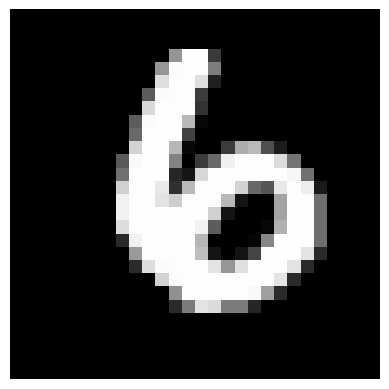

Label: 6


In [19]:
# No need to edit this. Just run the cell and move on

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()
print(f"Label: {label}")

### Demo 2.1: Building a Vanilla ConvNet

Let's walk through how to build a ConvNet using PyTorch layers. You can refer to the attached command glossary to read more about the layers. We'll follow the following architecture:

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Conv(64, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Flat} \\ \rightarrow \text{L(1600, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)} \rightarrow \text{Softmax}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size, with no padding and a stride of 1 by default.

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size, with no padding, the stride set to the same shape as the kernel by default.

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope.

- `Flat` is the flattening operation, which should flatten/reshape the tensor from a multi-dimensional tensor (batch_size, num_channels, width, height) into a "flat" tensor (batch_size, num_channels x width x height). The 2-dimensional result represents that each sample has only 1 dimension of "flattened" data. This has already been implemented for you

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features.

__Note:__ For all your networks hereon, the only constructor argument is `classes`. Do not add any other parameters to the `__init__` method. Remember not to hardcode for the number of classes and use the `classes` argument instead.

__Note:__ There is no need to include a Softmax layer in your neural network because we will be using [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function later, which already applies Softmax implicitly.

In [20]:
# Demo
class RawCNN(nn.Module):
    """
    CNN model using Conv2d and MaxPool2d layers.
    """
    def __init__(self, classes: int):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for MNIST
        """
        self.conv1 = nn.Conv2d(1, 32, (3,3))
        self.mp1 = nn.MaxPool2d((2,2))
        self.lrelu = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.mp2 = nn.MaxPool2d((2,2))

        self.l1 = nn.Linear(64*5*5, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.mp1(x)
        x = self.lrelu(x)

        x = self.conv2(x)
        x = self.mp2(x)
        x = self.lrelu(x)   
        
        x = x.view(-1, 64*5*5) # Flattening – do not remove this line

        x = self.l1(x)
        x = self.lrelu(x)
        x = self.l2(x)
        x = self.lrelu(x)
        out = self.l3(x)
        
        return out

# Test the network's forward pass
num_samples, num_channels, width, height = 20, 1, 28, 28
x = torch.rand(num_samples, num_channels, width, height)
net = RawCNN(10)
y = net(x)
print(y.shape) # torch.Size([20, 10])

torch.Size([20, 10])


### Concept: Dropout

__Dropout__ (*Srivastava et al., 2014*) is a regularisation technique that randomly shuts off neurons in a given layer. This means the output of the neuron is made to be __zero__. When building the dropout layer, we need to specify a probability value `p` that a neuron gets shut off.

A visualisation of one realisation when using dropout:

<img src="images/dropout.png" width=600>

### How Dropout helps
Dropout randomly disables neurons during training, which has a powerful regularization effect. By forcing the network to achieve good results with different subsets of active neurons at every step, it essentially trains an ensemble of many different, sparser networks simultaneously. This prevents overfitting because no single neuron can become overly specialized, ensuring a more robust and generalized model.

#### Dropout in PyTorch
To use Dropout in a network, we can create a `Dropout` layer in our `__init__` method of the model class:

```python
class Model(nn.Module):
    def __init__(self, ..., drop_prob):
        super().__init__()
        self.l1 = ...
        ...
        self.dropout = nn.Dropout(p=drop_prob)
        ...
        self.ln = ...

    def forward(self, x):
        x = self.l1(x)
        ...
        x = self.dropout(x)
        ...
        out = ...
        
        return out
```

__Note:__ Other that `nn.Dropout`, there is a `nn.Dropout2d` in PyTorch. Instead of randomly zero-ing out neurons, `Dropout2d` randomly zero-es out the entire channels of the input. 

`nn.Dropout` is best used with non-spatial data or data that has been flattened, which is typical for fully connected layers. `nn.Dropout2d` is designed for spatial data, making it ideal for use right after convolutional and pooling layers in CNNs.

For the sake of this problem set, You should choose one of them to be but __NOT both__ in your neural network.

---

### Task 2.1: Building a ConvNet with Dropout

Let's build the exact same network but with Dropout inside the architecture. You can refer to the attached command glossary to read more about the layers. Use the following architecture:

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(prob)} \rightarrow \\
\text{Conv(64, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(prob)} \rightarrow \\
\text{Flat} \rightarrow \text{L(1600, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(prob)} \rightarrow \\
\text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)} \rightarrow \text{Softmax}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size, with no padding and a stride of 1 by default.

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size, with no padding, the stride set to the same shape as the kernel by default.

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope.

- `Flat` is the flattening operation, which should flatten/reshape the tensor from a multi-dimensional tensor (batch_size, num_channels, width, height) into a "flat" tensor (batch_size, num_channels x width x height). The 2-dimensional result represents that each sample has only 1 dimension of "flattened" data. This has already been implemented for you

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features.
 
- [`DO`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) is Dropout with a dropping probability. Choose between `nn.Dropout` and `nn.Dropout2d` but __not both__ for your network.

You are highly encouraged to initialise all your layers in the `__init__` method.

__Reminder:__ Do not hardcode for the number of classes and the dropout probability. Use the `classes` and `drop_prob` constructor arguments instead.

__Note:__ There is no need to include a Softmax layer in your neural network, as technically, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which we are going to use as our loss function later, already applies Softmax implicitly.

In [21]:
class DropoutCNN(nn.Module):
    """
    CNN that uses Conv2d, MaxPool2d, and Dropout layers.
    """
    def __init__(self, classes: int, drop_prob: float = 0.5):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for MNIST
        drop_prob: probability of dropping a node in the neural network
        """
        """ YOUR CODE HERE """
        self.conv1 = nn.Conv2d(1, 32, (3,3))
        self.mp1 = nn.MaxPool2d((2,2))
        self.lrelu = nn.LeakyReLU(0.1)
        self.do1 = nn.Dropout(p=drop_prob)

        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.mp2 = nn.MaxPool2d((2,2))
        self.do2 = nn.Dropout(p=drop_prob)

        self.l1 = nn.Linear(64*5*5, 256)
        self.do3 = nn.Dropout(p=drop_prob)
        
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, classes)
        """ YOUR CODE END HERE """
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ YOUR CODE HERE """
        x = self.conv1(x)
        x = self.mp1(x)
        x = self.lrelu(x)
        x = self.do1(x)

        x = self.conv2(x)
        x = self.mp2(x)
        x = self.lrelu(x)
        x = self.do2(x)
        """ YOUR CODE END HERE """
        
        x = x.view(-1, 64*5*5) # Flattening – do not remove

        """ YOUR CODE HERE """
        x = self.l1(x)
        x = self.lrelu(x)
        x = self.do3(x)

        x= self.l2(x)
        x = self.lrelu(x)

        output = self.l3(x)
        return output
        """ YOUR CODE END HERE """



# Test cases
# Test your network's forward pass
num_samples, num_channels, width, height = 20, 1, 28, 28
x = torch.rand(num_samples, num_channels, width, height)
net = DropoutCNN(10)
y = net(x)
print(y.shape) # torch.Size([20, 10])

torch.Size([20, 10])


### Task 2.2: Training your Vanilla and Dropout CNNs

Here, write down the training loop in the function `train_model` to train the CNNs you have just created. It will take in the respective NN (vanilla or dropout), as well as training and testing __data loaders__ (more on this later) that return batches of images and their respective labels to train on. 

Use the `torch.optim.Adam(...)` optimizer and Cross Entropy Loss `nn.CrossEntropyLoss()`.

> Return the model and epoch losses.

Remember to extract the loss value from the `loss` tensor by using `loss.item()`.

__Tip:__ Don't be worried if your model takes a while to train. Your mileage may also vary depending on your CPU. But if you would like to speed things up, you can consider making use of your device's GPU to parallelize the matrix computations.

In [22]:
%%time 
# do not remove the above line
def train_model(loader: torch.utils.data.DataLoader, model: nn.Module):
    """
    PARAMS
    loader: the data loader used to generate training batches
    model: the model to train
  
    RETURNS
        the final trained model and losses
    """

    """
    YOUR CODE HERE
    - create the loss and optimizer
    """
    """ YOUR CODE HERE """
    loss_fn = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters())
    """ YOUR CODE END HERE """
    epoch_losses = []
    for i in range(10):
        epoch_loss = 0
        model.train()
        for idx, data in enumerate(loader):
            x, y = data
            """
            YOUR CODE HERE
            - reset the optimizer
            - perform forward pass
            - compute loss
            - perform backward pass
            """
            """ YOUR CODE HERE """
            optimiser.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimiser.step()
            """ YOUR CODE END HERE """

        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append(epoch_loss)
        print("Epoch: {}, Loss: {}".format(i, epoch_loss))
        

    return model, epoch_losses

print("======Training Vanilla Model======")
vanilla_model, losses = train_model(train_loader, RawCNN(10))
print("======Training Dropout Model======")
do_model, losses = train_model(train_loader, DropoutCNN(10))

======Training Vanilla Model======
Epoch: 0, Loss: 0.0
Epoch: 1, Loss: 0.0
Epoch: 2, Loss: 0.0
Epoch: 3, Loss: 0.0
Epoch: 4, Loss: 0.0
Epoch: 5, Loss: 0.0
Epoch: 6, Loss: 0.0
Epoch: 7, Loss: 0.0
Epoch: 8, Loss: 0.0
Epoch: 9, Loss: 0.0
======Training Dropout Model======
Epoch: 0, Loss: 0.0
Epoch: 1, Loss: 0.0
Epoch: 2, Loss: 0.0
Epoch: 3, Loss: 0.0
Epoch: 4, Loss: 0.0
Epoch: 5, Loss: 0.0
Epoch: 6, Loss: 0.0
Epoch: 7, Loss: 0.0
Epoch: 8, Loss: 0.0
Epoch: 9, Loss: 0.0
CPU times: total: 2h 38s
Wall time: 13min 24s


In [23]:
# do not remove – nothing to code here
# run this cell before moving on
# ensure get_accuracy from task 1.5 is defined

with torch.no_grad():
    vanilla_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_vanilla = vanilla_model(x)
        acc = get_accuracy(pred_vanilla, y)
        print(f"vanilla acc: {acc}")
        
    do_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_do = do_model(x)
        acc = get_accuracy(pred_do, y)
        print(f"drop-out (0.5) acc: {acc}")
        
"""
The network with Dropout might under- or outperform the network without
Dropout. However, in terms of generalisation, we are assured that the Dropout
network will not overfit – that's the guarantee of Dropout.

A very nifty trick indeed!
"""

vanilla acc: 0.992
drop-out (0.5) acc: 0.9922


"\nThe network with Dropout might under- or outperform the network without\nDropout. However, in terms of generalisation, we are assured that the Dropout\nnetwork will not overfit – that's the guarantee of Dropout.\n\nA very nifty trick indeed!\n"

### Task 2.3: Observing Effects of Dropout

Here, train your `DropoutCNN` with your `train_model(loader, model)` from Task 2.3, with `p=0.1` and `p=0.95` respectively. 

Explain why extreme values of Dropout don't work as well on neural networks. Look back at first principles – what does Dropout do in the first place? How does the `p` value affect how it does it? 

In [ ]:
%%time 
# do not remove – nothing to code here
# run this before moving on

print("======Training Dropout Model with Dropout Probability 0.10======")
do10_model, do10_losses = train_model(train_loader, DropoutCNN(10, 0.10))
print("======Training Dropout Model with Dropout Probability 0.95======")
do95_model, do95_losses = train_model(train_loader, DropoutCNN(10, 0.95))

======Training Dropout Model with Dropout Probability 0.10======
Epoch: 0, Loss: 0.0
Epoch: 1, Loss: 0.0
Epoch: 2, Loss: 0.0
Epoch: 3, Loss: 0.0
Epoch: 4, Loss: 0.0
Epoch: 5, Loss: 0.0
Epoch: 6, Loss: 0.0
Epoch: 7, Loss: 0.0
Epoch: 8, Loss: 0.0
Epoch: 9, Loss: 0.0
======Training Dropout Model with Dropout Probability 0.95======
Epoch: 0, Loss: 0.0


In [ ]:
# do not remove – nothing to code here
# run this cell before moving on
# but ensure get_accuracy from task 3.5 is defined

with torch.no_grad():
    do10_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_do = do10_model(x)
        acc = get_accuracy(pred_do, y)
        print(acc)

    do95_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred_do = do95_model(x)
        acc = get_accuracy(pred_do, y)
        print(acc)

### Concept: Sequential Model Building with PyTorch

All this while, we've been adding layers one by one as attributes inside the `__init__` method. This is a natural first step as we explore what each layer does separately. But now we can speed things up!

PyTorch lets you combine the declaration of multiple layers using the `nn.Sequential` API, by chaining them together in one call. It also allows you to build isolated modules that can exist on their own (either within a `nn.Module` class or otherwise) and be used as independent "mini models" on data tensors. Refer to https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html for more information about combining PyTorch modules to create your own.

__Note:__ You should not add an array of layers inside `nn.Sequential` i.e., it's `nn.Sequential(xyz, abc, mno)`, **not** `nn.Sequential([xyz, abc, mno])`.

### Demo 2.2: 3-layer Multilayer Perceptron for MNIST

In [ ]:
densenet = nn.Sequential(
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(1) # softmax dimension
            )

x = torch.rand(15, 784) # a batch of 15 MNIST images
y = densenet(x) # here we simply run the sequential densenet on the `x` tensor
print(y.shape) # a batch of 15 predictions

### Demo 2.3: 2-layer ConvNet for MNIST

In [ ]:
convnet = nn.Sequential(
                nn.Conv2d(1, 32, (3,3)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (3,3)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(36864, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(1) # softmax dimension
            )

x = torch.rand(15, 1, 28, 28) # a batch of 15 MNIST images
y = convnet(x) # here we simply run the sequential convnet on the `x` tensor
print (y.shape) # a batch of 15 predictions

## New dataset: CIFAR-10
Using what you've learned with MNIST, apply the techniques to CIFAR-10, a dataset of 60K training and 10K testing images comprising of real-life objects corresponding to the following 10 classes:

- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck

Each image is $3 \times 32 \times 32$, meaning we operate on 3 color channels RGB, and no longer just 1 channel (grayscale). Some example images:

![PyTorch](images/cifar.jpg)

### Concept: Data Augmentation

In reality, finding a well-representative, balanced dataset is difficult. To address this issue, we use __Data Augmentation__. It refers to the process of transforming data in a training dataset to generate more samples to expand the training dataset.

Here, we will pick images from the original dataset `x_train`, perform some transformations $F$ on them, and append them to `x_train`. This should generate new images from the base images, containing similar features to the original images that can be learnt.

Of course, the impact of data augmentation on model training depends on the types of augmentation used. Here are some common ones used:

- Normalisation
- Horizontal and Vertical Flipping
- Rotation
- Blurring
- Adding noise
- Skewing
- Cropping (zooming in or out)
- Brightness and Contrast
- Shuffling pixels

This results in a wide variety of new samples being created that can be used for training.

### The `transforms` module

Here, we are going to use the `transforms` module from PyTorch to transform the images in our dataset. It contains all kinds of image transformations from `rotate` to `resize`. Check out the full list of augmentations on the PyTorch documentation: https://pytorch.org/vision/stable/transforms.html.

Explore the following example to see how the transformations work.

In [ ]:
cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=transforms.ToTensor())
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

train_features, train_labels = next(iter(cifar_train_loader))
img = train_features[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
transform = transforms.Compose([transforms.RandomHorizontalFlip()
                                # YOUR CODE HERE
                                ]) # add in your own transformations to test
tensor_img = transform(img)
ax1.imshow(img.permute(1,2,0))
ax1.axis("off")
ax1.set_title("Before Transformation")
ax2.imshow(tensor_img.permute(1, 2, 0))
ax2.axis("off")
ax2.set_title("After Transformation")
plt.show()

### Task 2.4: Picking Data Augmentations

Pick your favourite data augmentations! Then, you can apply them to the images from the dataset.

We've already started you off with the necessary one `ToTensor()` that converts the original JPEG-format image to the PyTorch `Tensor` format. Refer to the command glossary to add your custom data augmentations from the list we've provided. 

**Choose at least 2 additional augmentations.** Tell us which augmentations you chose to use and why. Then tell us which augmentations you avoided and why. 

__Note:__ Feel free to use any augmentations you wish from the full list of augmentations shown on the [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html)! There's no need to be restricted to the list that we've provided.

Be creative and try different things! We recommend using trial and error to get the best performing network. Are you surprised by which transformations happen to work the best?

__Note:__ Do ensure your augmentations retain the 3-dimensional shape of the CIFAR-10 images. The final images should still have the shape `(3, 32, 32)`.

In [ ]:
# pick your data augmentations here
def get_augmentations() -> transforms.Compose:
    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # standardise pixel value range, ensures all channels have similar distribution
        transforms.RandomHorizontalFlip(0.5), # orientation of image does not affect its identification 
    ])
    
    return T

Create your data loaders that return batches of data:

In [ ]:
# do not remove this cell
# run this before moving on

T = get_augmentations()

cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=T)
cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=T)

"""
if you feel your computer can't handle too much data, you can reduce the batch
size to 64 or 32 accordingly, but it will make training slower. 

We recommend sticking to 128 but dochoose an appropriate batch size that your
computer can manage. The training phase tends to require quite a bit of memory.

CIFAR-10 images have dimensions 3x32x32, while MNIST is 1x28x28
"""
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=10000)

### Task 2.5: Build a ConvNet for CIFAR-10

Your task is to build a decently-sized ConvNet (i.e., $\geq 4$ layers). Design your ConvNet with the following architecture

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP((2,2))} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Conv(64, (3,3))} \rightarrow \text{MP((2,2))} \rightarrow \text{LReLU(0.1)} \rightarrow \text{GAP} \\ \rightarrow \text{L(64, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope

- `GAP` is the Global Average Pooling operation (already implemented for you)

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features

---

You must use the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) API to build two parts:
1. The `self.conv` attribute must contain all the Convolutional, Pooling, and Activation layers
2. The `self.fc` attribute must contain all the fully-connected layers after the flattening

The `self.conv` and `self.fc` attributes are already given to you. All you need to do is chain the arbitrary `nn.XYZ` layers together based on the architecture stated above.

__Note:__ The flattening is already done for you via Global Average Pooling (GAP) in the `forward` method. Do not add the Softmax activation in the `self.fc` Sequential module.

__Reminder:__ Do not hardcode for the number of classes. Use the `classes` argument instead.

In [ ]:
class CIFARCNN(nn.Module):
    def __init__(self, classes: int):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for CIFAR-10
        """
        self.conv = nn.Sequential(
            
            nn.Conv2d(3, 32, (3,3)),
            nn.MaxPool2d((2,2)),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, (3,3)),
            nn.MaxPool2d((2,2)),
            nn.LeakyReLU(0.1)
                    )

        self.fc = nn.Sequential(
            nn.Linear(64, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, classes)
                    )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ YOUR CODE HERE """
        x = self.conv(x)
        x = x.view(x.shape[0], 64, 6*6).mean(2) # GAP – do not remove this line
        """ YOUR CODE HERE """
        out = self.fc(x)
        """ YOUR CODE END HERE """
        return out

### Train your ConvNet on CIFAR-10

In [ ]:
%%time
# do not remove – nothing to code here
# run this cell before moving on

cifar10_model, losses = train_model(cifar_train_loader, CIFARCNN(10))

### Test the CIFAR-10 ConvNet model using the testing data loader

In [ ]:
# do not remove – nothing to code here
# run this cell before moving on
# but ensure get_accuracy from task 3.5 is defined

with torch.no_grad():
    cifar10_model.eval()
    for i, data in enumerate(cifar_test_loader):
        x, y = data
        x, y = x.to(device), y.to(device)
        pred = cifar10_model(x)
        acc = get_accuracy(pred, y)
        print(f"cifar accuracy: {acc}")
        
# don't worry if the CIFAR-10 accuracy is low, it's a tough dataset to crack.
# as long as you get something shy of 50%, you should be alright!

## 3 - Recurrent Neural Networks (RNNs)
In this part, we'll explore how an RNN works, and create a simple RNN model to predict values of a sine wave based on prior inputs.

### Packages
The necessary packages are imported in the cell below. Please make sure that you run this cell before proceeding.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(2109)
np.random.seed(2109)

In [ ]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


### Concept: Memory

Traditional models like MLPs or CNNs see each input on its own—they have no memory of what came before. An RNN, on the other hand, is built to handle sequences. It keeps a "memory" of past information through a hidden state, allowing it to make predictions that depend on earlier steps in the sequence.

### Demo 3.1 - RNN Cell
<center><img src="images/rnn_superscript_updated.png" style="width:800px"></center>

At the core of the RNN is the RNN cell, which processes one time step of the sequence at a time. For each time step, the cell updates its hidden state based on the current input and the previous hidden state.

We first implement the computations for a single time step. The diagram below describes the operations for a single time step of an RNN cell.
<center><img src="images/rnn_cell_superscript_updated.png" style="width:800px"></center>

__Note__: an RNN cell outputs the hidden state $h^{[t]}$, but the function that you'll implement `rnn_cell_forward`, also calculates the prediction $\hat{y}^{[t]}$. Keep in mind that the activation functions within the RNN cell can be replaced with other activation functions. This implementation uses tanh and softmax but they can be replaced by other activation functions as well.

In [ ]:
def rnn_cell_forward(xt, h_prev, Wxh, Whh, Why, bh, by):
    """
    Implements a single forward step of the RNN-cell

    Args:
        xt: 2D tensor of shape (nx, m)
            Input data at timestep "t"
        h_prev: 2D tensor of shape (nh, m)
            Hidden state at timestep "t-1"
        Wxh: 2D tensor of shape (nx, nh)
            Weight matrix multiplying the input
        Whh: 2D tensor of shape (nh, nh)
            Weight matrix multiplying the hidden state
        Why: 2D tensor of shape (nh, ny)
            Weight matrix relating the hidden-state to the output
        bh: 1D tensor of shape (nh, 1)
            Bias relating to next hidden-state
        by: 2D tensor of shape (ny, 1)
            Bias relating the hidden-state to the output

    Returns:
        yt_pred -- prediction at timestep "t", tensor of shape (ny, m)
        h_next -- next hidden state, of shape (nh, m)
    """
    h_next = torch.tanh(Whh.T @ h_prev + Wxh.T @ xt + bh)
    yt_pred = F.softmax(Why.T @ h_next + by, dim=0)
    return yt_pred, h_next

### Demo 3.2 - Generate Sine Wave Data

We'll use `torch.linspace(start, end, steps)` to create a sequence of evenly spaced values between 0 and $8\pi$ over `num_time_steps` intervals. This will serve as the x-values (time points) for the sine wave.

In [ ]:

def generate_sine_wave(num_time_steps):
    """
    Generates a sine wave data

    Args:
        num_time_steps: int
            Number of time steps
    Returns:
        data: 1D tensor of shape (num_time_steps,)
            Sine wave data with corresponding time steps
    """
    x = torch.linspace(0, 8*torch.pi, num_time_steps)
    data = torch.sin(x)
    return data

In [ ]:
num_time_steps = 500
sine_wave_data = generate_sine_wave(num_time_steps)

# Plot the sine wave
plt.plot(sine_wave_data)
plt.title('Sine Wave')
plt.show()

### Demo 3.3 Create sequences

When training RNNs, it's common to divide time series data into overlapping windows. The label used for comparison is the next value in the sequence.

For example if we have series of $n$ data points and a window size of 3, the input sequences are $[x^{[1]}, x^{[2]}, x^{[3]}]$ to predict $x^{[4]}$, $[x^{[2]}, x^{[3]}, x^{[4]}]$ to predict $x^{[5]}$, $[x^{[3]}, x^{[4]}, x^{[5]}]$, to predict $x^{[6]}$, and so on.

Below is our implementation of `create_sequences` which generates sequences and their corresponding labels from a given sine wave.

In [ ]:
def create_sequences(sine_wave, seq_length):
    """
    Create overlapping sequences from the input time series and generate labels 
    Each label is the value immediately following the corresponding sequence.
    
    Args:
        sine_wave: A 1D tensor representing the time series data (e.g., sine wave).
        seq_length: int. The length of each sequence (window) to be used as input to the RNN.

    Returns: 
        windows: 2D tensor where each row is a sequence (window) of length `seq_length`.
        labels: 1D tensor where each element is the next value following each window.
    """
    windows = sine_wave.unfold(0, seq_length, 1)
    labels = sine_wave[seq_length:]
    return windows[:-1], labels

In [ ]:
# Create sequences and labels
seq_length = 20
sequences, labels = create_sequences(sine_wave_data, seq_length)
# Add extra dimension to match RNN input shape [batch_size, seq_length, num_features]
sequences = sequences.unsqueeze(-1)
sequences.shape

In [ ]:
# Split the sequences into training data (first 80%) and test data (remaining 20%) 
train_size = int(len(sequences) * 0.8)
train_seqs, train_labels = sequences[:train_size], labels[:train_size]
test_seqs, test_labels = sequences[train_size:], labels[train_size:]

### Task 3.1: Building RNN Model

Now we're ready to build the RNN, following the architecture:
$$x \rightarrow \text{RNN} \rightarrow \text{Linear}(1)$$

- [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html): a basic recurrent layer in PyTorch. It takes an input of sequences and returns output for each time step, and the hidden state of the last time step. The `hidden_size` determines the number of hidden units in the RNN.
 
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): fully connected layer. The output from the RNN's last hidden state will be passed through this layer to predict a single value (the next time step in the series)

We'll do so by defining the `__init__` and `forward` functions in our `SineRNN` class, which inherits from `nn.Module`.

__Note:__ For all your networks hereon, the only constructor argument is `classes`. Do not add any other parameters to the `__init__` method. Remember not to hardcode and use the `classes` argument instead. For RNN layer, use `batch_first=True` to ensure that the batch dimension is handled as the first input dimension.

In [ ]:
class SineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the SineRNN model.

        Args:
            input_size (int): The number of input features per time step (typically 1 for univariate time series).
            hidden_size (int): The number of units in the RNN's hidden layer.
            output_size (int): The size of the output (usually 1 for predicting a single value).
        """
        super(SineRNN, self).__init__()
        """ YOUR CODE HERE """
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        """ YOUR CODE END HERE """
        
    def forward(self, x):
        """ YOUR CODE HERE """
        output, hn = self.rnn(x)
        last_step_out = output[:, -1, :]
        output = self.fc(last_step_out)
        return output
        """ YOUR CODE END HERE """

In [ ]:
# Test cases
input_size = output_size = 1
hidden_size = 50
model = SineRNN(input_size, hidden_size, output_size).to(device)
assert [layer.detach().numpy().shape for _, layer in model.named_parameters()]\
      == [(50, 1), (50, 50), (50,), (50,), (1, 50), (1,)]

### Training

In [ ]:
# Define loss function, and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_seqs)
    loss = criterion(outputs.squeeze(), train_labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

### Evaluating

Once training is complete, we can evaluate the model by plotting its predictions against the actual sine wave. We use a portion of test data that the model hasn't seen during training to check how well it generalizes.

In [ ]:
# Predict on unseen data
model.eval()
y_pred = []
input_seq = test_seqs[0]  # Start with the first testing sequence

with torch.no_grad():
    for _ in range(len(test_seqs)):
        output = model(input_seq)
        y_pred.append(output.item())

        # Use the predicted value as the next input sequence
        next_seq = torch.cat((input_seq[1:, :], output.unsqueeze(0)), dim=0)
        input_seq = next_seq

# Plot the true sine wave and predictions
plt.plot(sine_wave_data, c='gray', label='Actual data')
plt.scatter(np.arange(seq_length + len(train_labels)), sine_wave_data[:seq_length + len(train_labels)], marker='.', label='Train')
x_axis_pred = np.arange(len(sine_wave_data) - len(test_labels), len(sine_wave_data))
plt.scatter(x_axis_pred, y_pred, marker='.', label='Predicted')
plt.legend(loc="lower left")
plt.show()

### Demo 3.4: Appending Noise to Sequences

In real-world data, sequences often contain noise or fluctuations that can make predictions more challenging. To simulate this, we can append random noise to our sine wave sequences.

In this demo, we will append a sequence of noises to the sine wave sequences. The model has to learn to predict the sine wave despite the added noise.

In [63]:
def create_sequences_with_noise(sine_wave, sine_wave_length, noise_length):
    """
    Create overlapping sequences from the input time series and generate labels.
    Each label is the value immediately following the corresponding sequence.
    Additionally, noise of the specified length is appended to the sequences.

    Args:
        sine_wave: A 1D tensor representing the time series data (e.g., sine wave).
        sine_wave_length: int. The length of the sine wave window.
        noise_length: int. The length of noise to be appended to each sequence.

    Returns:
        windows: 2D tensor where each row is a sequence of length `sine_wave_length + noise_length`.
        labels: 1D tensor where each element is the next value following each window.
    """
    windows = sine_wave.unfold(0, sine_wave_length, 1)
    labels = sine_wave[sine_wave_length:]
    noise = torch.randn(windows.shape[0], noise_length)
    windows = torch.cat((windows, noise), dim=1)
    return windows[:-1], labels

In [64]:
# Create sequences and labels
sine_wave_length = 20
noise_length = 20
sequences, labels = create_sequences_with_noise(sine_wave_data, sine_wave_length, noise_length)
# Add extra dimension to match RNN input shape [batch_size, seq_length, num_features]
sequences = sequences.unsqueeze(-1)
sequences.shape

torch.Size([480, 40, 1])

In [65]:
# Split the sequences into training data (first 80%) and test data (remaining 20%) 
train_size = int(len(sequences) * 0.8)
train_seqs, train_labels = sequences[:train_size], labels[:train_size]
test_seqs, test_labels = sequences[train_size:], labels[train_size:]

### Training

In [66]:
# Define model
input_size = output_size = 1
hidden_size = 50
model = SineRNN(input_size, hidden_size, output_size).to(device)

# Define loss function, and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [67]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_seqs)
    loss = criterion(outputs.squeeze(), train_labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [20/200], Loss: 0.507648
Epoch [40/200], Loss: 0.501002
Epoch [60/200], Loss: 0.485698
Epoch [80/200], Loss: 0.531568
Epoch [100/200], Loss: 0.511691
Epoch [120/200], Loss: 0.508216
Epoch [140/200], Loss: 0.499800
Epoch [160/200], Loss: 0.505752
Epoch [180/200], Loss: 0.502910
Epoch [200/200], Loss: 0.507665


### Evaluating

Test loss: tensor(0.4985)


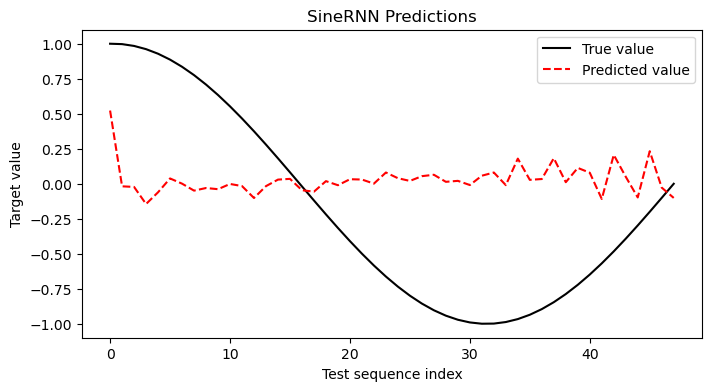

In [68]:
model.eval()
with torch.no_grad():
    y_pred = model(test_seqs).squeeze()
    y_true = test_labels.squeeze()

print("Test loss:", criterion(y_pred, y_true))

plt.figure(figsize=(8, 4))
plt.plot(y_true[1::2].numpy(), label="True value", color='black')
plt.plot(y_pred[1::2].numpy(), '--', label="Predicted value", color='red')
plt.title("SineRNN Predictions")
plt.xlabel("Test sequence index")
plt.ylabel("Target value")
plt.legend()
plt.show()

As we increase the length of the noise appended to the sequence, it gets harder and harder for the RNN to predict the sine wave accurately.

Note that RNNs processes the data sequentially, so RNNs often face difficulties retaining information over long sequences.

# 4 Attention Mechanism and Transformers

In this task, you will train a transformer model to see if it can overcome these limitations. The transformer model will use the architecture provided below.

![](images/transformer.png)

## Task 4.1: Positional Encoding Layer

Positional encoding explicitly injects positional information into the inputs. We use the positional encoding scheme discussed in lecture, reproduced as follows:

$$
PE{(i, 2k)} = \sin\left(\dfrac{i}{10000^{2k/d}}\right) \\
PE{(i, 2k+1)} = \cos\left(\dfrac{i}{10000^{2k/d}}\right)
$$

where $d$ is the model's hidden dimension.

Implement the `PositionalEncoding` class, which extends from `nn.Module`, that generates positional encodings for input sequences. **In your implementation, you may assume that `hidden_size` is even.**

In [69]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        # You do not need to change anything in this function.
        super(PositionalEncoding, self).__init__()

    def forward(self, x):
        """
        Adds positional encoding to the input tensor.

        You should use vectorized operations to compute the positional encoding.
        The use of Python loops is not allowed.

        Args:
            x: Input tensor of shape (batch_size, seq_len, hidden_size)
        """
        """ YOUR CODE HERE """        
        batch_size, seq_len, hidden_size = x.shape
        pe = torch.zeros(seq_len, hidden_size)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).repeat(batch_size, 1, 1)
        return x + pe.to(x.device)        
        """ YOUR CODE END HERE """

In [70]:
# Test cases
encoder = PositionalEncoding()
x0 = torch.zeros((1, 2, 4))
y0 = encoder(x0)
a0 = torch.tensor([[[0.0000, 1.0000, 0.0000, 1.0000],
                    [0.8415, 0.5403, 0.0100, 0.9999]]])
assert torch.allclose(y0, a0, atol=1e-4)

x1 = torch.ones((1, 4, 6))
y1 = encoder(x1)
a1 = torch.tensor([[[1.0000, 2.0000, 1.0000, 2.0000, 1.0000, 2.0000],
                    [1.8415, 1.5403, 1.0464, 1.9989, 1.0022, 2.0000],
                    [1.9093, 0.5839, 1.0927, 1.9957, 1.0043, 2.0000],
                    [1.1411, 0.0100, 1.1388, 1.9903, 1.0065, 2.0000]]])
assert torch.allclose(y1, a1, atol=1e-4)

## Demo 4.1: The Transformer Model

Here, we will implement the model architecture for the transformer model using PyTorch. The transformer model consists of a single encoder layer with a specified hidden dimension in the feed-forward network.

A layer in the transformer model is defined using `nn.TransformerEncoderLayer`, with the following minimal usage:

```python
encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=2048, batch_first=False)
```
- `d_model` is the hidden dimension of the model.
- `nhead` is the number of attention heads. Each attention head is an independent self-attention mechanism that could possibly learn different aspects of the input sequence. In this transformer model, we will set `nhead=1` to implement only one self-attention mechanism.
- `dim_feedforward` is the hidden dimension of the feed-forward network.
- `batch_first=True` ensures that the input and output tensors are of shape `(batch_size, seq_length, hidden_dim)`, which is convenient for our implementation.


The transformer encoder is then defined using `nn.TransformerEncoder`, which takes the encoder layer and the number of layers as arguments:

```python
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
```
- `num_layers=1` specifies that we will use only one encoder layer.

There are other optional parameters that can be set, you may refer to the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) for more details.

In [71]:
class TransformerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initializes the TransformerNN model. We use the same hidden size for the feedforward network and the Transformer encoder.

        Args:
            input_size (int): The number of input features per time step (typically 1 for univariate time series).
            hidden_size (int): The number of units in the Transformer's hidden layers.
            output_size (int): The size of the output (usually 1 for predicting a single value).
        """
        super(TransformerNN, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoder = PositionalEncoding()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, dim_feedforward=hidden_size, nhead=1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoder(x)
        x = self.transformer_encoder(x)

        # The encoder outputs a sequence of hidden states, so
        # we take the mean across the sequence length dimension.
        x = x.mean(dim=1)

        out = self.fc_out(x)
        return out

### Training

In [72]:
model = TransformerNN(input_size=1, hidden_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [73]:
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_seqs)
    loss = criterion(outputs.squeeze(), train_labels)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [20/200], Loss: 0.165998
Epoch [40/200], Loss: 0.113740
Epoch [60/200], Loss: 0.048921
Epoch [80/200], Loss: 0.008003
Epoch [100/200], Loss: 0.004086
Epoch [120/200], Loss: 0.003480
Epoch [140/200], Loss: 0.002733
Epoch [160/200], Loss: 0.003107
Epoch [180/200], Loss: 0.002303
Epoch [200/200], Loss: 0.002105


### Evaluating

Test loss: tensor(0.0017)


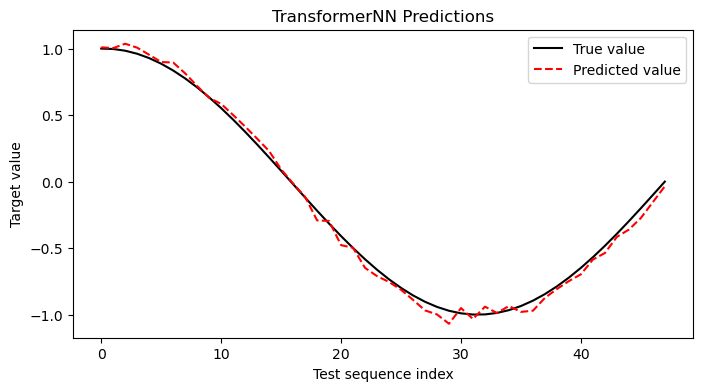

In [74]:
model.eval()
with torch.no_grad():
    y_pred = model(test_seqs).squeeze()
    y_true = test_labels.squeeze()

print("Test loss:", criterion(y_pred, y_true))

plt.figure(figsize=(8, 4))
plt.plot(y_true[1::2].numpy(), label="True value", color='black')
plt.plot(y_pred[1::2].numpy(), '--', label="Predicted value", color='red')
plt.title("TransformerNN Predictions")
plt.xlabel("Test sequence index")
plt.ylabel("Target value")
plt.legend()
plt.show()

## Task 4.2: Visualizing Attention Scores

We can visualize the attention scores from the transformer model to understand which parts of the input sequence the model focuses on when making predictions.

Here are 3 different plots of attention scores, one of which is actually taken from the self-attention layer of our trained transformer model. Which of the 3 plots **most likely** corresponds to the attention scores from our trained transformer model? Explain your reasoning.

**Plot A**

![](images/attention_A.png)

**Plot B**

![](images/attention_B.png)

**Plot C**

![](images/attention_C.png)

## Task 4.3: Comparing Transformers with or without Positional Encoding

Currently, the transformer model makes use of the positional encoding layer. Train another transformer model **without the positional encoding layer** on the same dataset and evaluate its performance.

Attach the plots of both models on Coursemology. Discuss the differences in performance between the two models and explain why positional encoding is important for transformer models when dealing with sequential data.

--- Training Model WITHOUT Positional Encoding ---
Training model: TransformerNN_NoPE...
  Epoch [50/200], Loss: 0.154328
  Epoch [100/200], Loss: 0.139656
  Epoch [150/200], Loss: 0.129331
  Epoch [200/200], Loss: 0.128654
Training complete.

--- Evaluating Model ---
Test Loss (Without PE): 0.106916


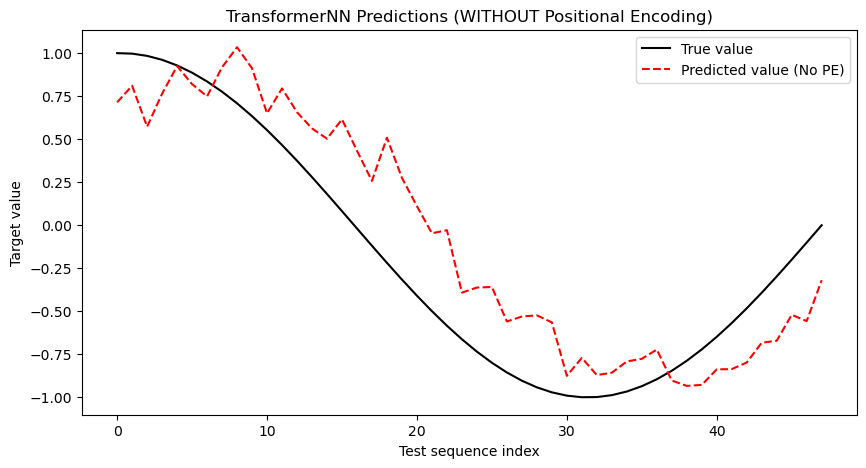

In [76]:
# You may use this cell and create new cells to experiment.
# 1. Define the Transformer Model WITHOUT Positional Encoding
class TransformerNN_NoPE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TransformerNN_NoPE, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        # self.positional_encoder is removed
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, dim_feedforward=hidden_size, nhead=1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        # The positional_encoder line is removed
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        out = self.fc_out(x)
        return out

# 2. Helper function to train a model
def train_a_model(model, train_seqs, train_labels):
    print(f"Training model: {model.__class__.__name__}...")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 200
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        # Ensure data is on the same device as the model
        outputs = model(train_seqs.to(device))
        loss = criterion(outputs.squeeze(), train_labels.to(device))
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    print("Training complete.")
    return model.to(device) # Ensure model is on the correct device

# 3. Train the new model
print("--- Training Model WITHOUT Positional Encoding ---")
model_no_pe = TransformerNN_NoPE(input_size=1, hidden_size=50, output_size=1).to(device)
model_no_pe = train_a_model(model_no_pe, train_seqs, train_labels)

# 4. Evaluate and Plot
print("\n--- Evaluating Model ---")
model_no_pe.eval()
with torch.no_grad():
    y_pred_no_pe = model_no_pe(test_seqs.to(device)).squeeze().cpu().numpy()

y_true = test_labels.squeeze().cpu().numpy()
loss_no_pe = nn.MSELoss()(torch.tensor(y_pred_no_pe), torch.tensor(y_true))
print(f"Test Loss (Without PE): {loss_no_pe.item():.6f}")

# Plot 2: Model WITHOUT Positional Encoding
plt.figure(figsize=(10, 5))
plt.plot(y_true[1::2], label="True value", color='black')
plt.plot(y_pred_no_pe[1::2], '--', label="Predicted value (No PE)", color='red')
plt.title("TransformerNN Predictions (WITHOUT Positional Encoding)")
plt.xlabel("Test sequence index")
plt.ylabel("Target value")
plt.legend()
plt.show() # or plt.savefig("transformer_without_pe.png")

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer,"and click "Save." After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission." Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading.

*Have fun and enjoy coding.*